# [AI 504] Programming for AI, Fall 2021
# Practice 10: Transformers
-----

#### [Notifications]
- If you have any questions, feel free to ask
- For additional questions, send emails: yeonsu.k@kaist.ac.kr    
      

     
     
# Table of contents
1. [Prepare input](#1)
2. [Implement Transformer](#2)
3. [Train and Evaluate](#3)
4. [Visualize attention](#4)



# Prepare essential packages

In [1]:
%matplotlib inline
!git clone https://github.com/sjpark9503/attentionviz.git
!python -m spacy download de
!python -m spacy download en

Cloning into 'attentionviz'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 10), reused 19 (delta 4), pack-reused 0
Receiving objects: 100% (30/30), 19.54 KiB | 6.51 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2023-11-07 06:16:54.232836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 06:16:54.232884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 06:16:54.232929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 06:16:54.262723: I te

# I. Prepare input
<a id='1'></a>

In [2]:
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-datase

Cloning into 'multi30k-datase'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 313 (delta 17), reused 21 (delta 16), pack-reused 281
Receiving objects: 100% (313/313), 18.21 MiB | 18.39 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Submodule 'scripts/subword-nmt' (https://github.com/rsennrich/subword-nmt.git) registered for path 'scripts/subword-nmt'
Cloning into '/content/multi30k-datase/scripts/subword-nmt'...
remote: Enumerating objects: 597, done.        
remote: Counting objects: 100% (21/21), done.        
remote: Compressing objects: 100% (17/17), done.        
remote: Total 597 (delta 8), reused 12 (delta 4), pack-reused 576        
Receiving objects: 100% (597/597), 252.23 KiB | 1020.00 KiB/s, done.
Resolving deltas: 100% (357/357), done.
Submodule path 'scripts/subword-nmt': checked out '80b7c1449e2e26673fb0b5cae993fe2d0dc23846'


In [3]:
!find multi30k-datase/ -name '*.gz' -exec gunzip {} \;

We've already learned how to preprocess the text data in previous lectures.

You can see some detailed explanation about translation datasets in [torchtext](https://pytorch.org/text/), [practice session,week 9](https://classum.com/main/course/7726/103) and [PyTorch NMT tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)

In [4]:
import spacy
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import os
import io
from torch.nn.utils.rnn import pad_sequence

# Load spaCy models for tokenization
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Tokenization function for German and English
def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

# Define the custom Dataset class
class TranslationDataset(Dataset):
    def __init__(self, root_dir, split):
        self.root_dir = root_dir
        self.split = split

        self.data_files = {
            'train': ('train.de', 'train.en'),
            'valid': ('val.de', 'val.en'),
            'test': ('test_2016_flickr.de', 'test_2016_flickr.en')
        }

        self.de_file_path = os.path.join(self.root_dir, self.data_files[self.split][0])
        self.en_file_path = os.path.join(self.root_dir, self.data_files[self.split][1])

        with io.open(self.de_file_path, mode='r', encoding='utf-8') as de_file, \
             io.open(self.en_file_path, mode='r', encoding='utf-8') as en_file:
            self.de_sentences = de_file.readlines()
            self.en_sentences = en_file.readlines()

    def __len__(self):
        return len(self.de_sentences)

    def __getitem__(self, idx):
        de_sentence = tokenize_de(self.de_sentences[idx].strip())
        en_sentence = tokenize_en(self.en_sentences[idx].strip())
        return {'SRC': de_sentence, 'TRG': en_sentence}

# Define the Vocab class
class Vocab:
    def __init__(self, counter, min_freq):
        self.itos = ['<pad>', '<sos>', '<eos>', '<unk>']
        self.stoi = {token: i for i, token in enumerate(self.itos)}
        self.min_freq = min_freq
        self.build_vocab(counter)

    def build_vocab(self, counter):
        for word, freq in counter.items():
            if freq >= self.min_freq and word not in self.stoi:
                self.stoi[word] = len(self.itos)
                self.itos.append(word)

    def numericalize(self, tokens):
        return [self.stoi.get(token, self.stoi['<unk>']) for token in tokens]

# Function to build a counter of words from the dataset
def build_counter(dataset):
    counter = Counter()
    for i in range(len(dataset)):
        example = dataset[i]
        counter.update(example['SRC'])
        counter.update(example['TRG'])
    return counter

# Create the datasets
train_data = TranslationDataset(root_dir='/content/multi30k-datase/data/task1/raw', split='train')
valid_data = TranslationDataset(root_dir='/content/multi30k-datase/data/task1/raw', split='valid')
test_data = TranslationDataset(root_dir='/content/multi30k-datase/data/task1/raw', split='test')

# Build the counter and vocabularies
counter = build_counter(train_data)
SRC_vocab = Vocab(counter, min_freq=2)
TRG_vocab = Vocab(counter, min_freq=2)

# Define the collate function to process batches
def collate_fn(batch):
    src_batch = [torch.tensor(SRC_vocab.numericalize(item['SRC'])) for item in batch]
    trg_batch = [torch.tensor(TRG_vocab.numericalize(item['TRG'])) for item in batch]

    src_batch_padded = pad_sequence(src_batch, padding_value=SRC_vocab.stoi['<pad>'], batch_first=True)
    trg_batch_padded = pad_sequence(trg_batch, padding_value=TRG_vocab.stoi['<pad>'], batch_first=True)

    return {'SRC': src_batch_padded, 'TRG': trg_batch_padded}


# Set device for DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define batch size
BATCH_SIZE = 128


train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_iterator = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_iterator = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# II. Implement Transformer
<a id='2'></a>
In practice 10, we will learn how to implement the __[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) (Vaswani et al., 2017)__

The overall architecutre is as follows:
<div>
<img src="http://incredible.ai/assets/images/transformer-architecture.png" width=400)/>
</div>


## 1. Basic building blocks

In this sections, we will build blocks of the transformer: [Multi-head attention](#1a), [Position wise feedforward network](#1b) and [Positional encoding](#1c)

### a. Attention
<a id='1a'></a>
In this section, you will implement scaled dot-product attention and multi-head attention.

__Scaled dot product:__
![picture](http://incredible.ai/assets/images/transformer-scaled-dot-product.png)



<div>

__Multi-head attention:__
<img src="http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width=650)/>
* Equation:
$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$
</div>

<div>

__Query, Key and Value projection:__
<img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation.png" width=400)/>
</div>


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class MultiHeadAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        emb_dim,
        num_heads,
        dropout=0.0,
        bias=False,
        encoder_decoder_attention=False,  # otherwise self_attention
        causal = False
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads
        assert self.head_dim * num_heads == self.emb_dim, "emb_dim must be divisible by num_heads"

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)


    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_heads,
            self.head_dim,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
        # This is equivalent to
        # return x.transpose(1,2)


    def scaled_dot_product(self,
                           query: torch.Tensor,
                           key: torch.Tensor,
                           value: torch.Tensor,
                           attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.emb_dim) # QK^T/sqrt(d)

        if attention_mask is not None:
            attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1), float("-inf"))

        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V

        return attn_output, attn_probs


    def MultiHead_scaled_dot_product(self,
                       query: torch.Tensor,
                       key: torch.Tensor,
                       value: torch.Tensor,
                       attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.head_dim) # QK^T/sqrt(d)

        # Attention mask
        if attention_mask is not None:
            if self.causal:
              # (seq_len x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
              # (batch_size x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))


        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights


    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        attention_mask: torch.Tensor = None,
        ):

        q = self.q_proj(query)
        # Enc-Dec attention
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        # Self attention
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.MultiHead_scaled_dot_product(q,k,v,attention_mask)
        return attn_output, attn_weights


### b. Position-wise feed-forward network
<a id='1b'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [6]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x + residual # residual connection for preventing gradient vanishing

### c. Sinusoidal Positional Encoding
<a id='1c'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [7]:
import numpy as np

# Since Transformer contains no recurrence and no convolution,
# in order for the model to make use of the order of the sequence,
# we must inject some information about the relative or absolute position of the tokens in the sequence.
# To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks.
# There are many choices of positional encodings, learned and fixed

class SinusoidalPositionalEmbedding(nn.Embedding):

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim)
        self.weight = self._init_weight(self.weight) # self.weight => nn.Embedding(num_positions, embedding_dim).weight

    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = nn.Parameter(torch.zeros(out.shape))
        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
                pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
        pe.detach_()

        return pe

    @torch.no_grad()
    def forward(self, input_ids):
      bsz, seq_len = input_ids.shape[:2]
      positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
      return super().forward(positions)


## 2. Transformer Encoder

Now we have all basic building blocks which are essential to build Transformer.

Let's implement Transformer step-by-step

### a. Encoder layer
In this section, we will implement single layer of Transformer encoder.
<div>
<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width=200)/>
</div>

In [8]:

class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout)
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.dropout = config.dropout
        self.activation_fn = nn.ReLU()
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)

    def forward(self, x, encoder_padding_mask):

        residual = x
        x, attn_weights = self.self_attn(query=x, key=x, attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)
        if torch.isinf(x).any() or torch.isnan(x).any():
            clamp_value = torch.finfo(x.dtype).max - 1000
            x = torch.clamp(x, min=-clamp_value, max=clamp_value)
        return x, attn_weights


### b. Encoder

Stack encoder layers and build full Transformer encoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()

        self.dropout = config.dropout

        emb_dim = embed_tokens.embedding_dim
        self.padding_idx = embed_tokens.padding_idx
        self.max_source_positions = config.max_position_embeddings

        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
                config.max_position_embeddings, config.emb_dim, self.padding_idx
            )

        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])

    def forward(self, input_ids, attention_mask=None):

        inputs_embeds = self.embed_tokens(input_ids)
        embed_pos = self.embed_positions(input_ids)
        x = inputs_embeds + embed_pos
        x = F.dropout(x, p=self.dropout, training=self.training)

        self_attn_scores = []
        for encoder_layer in self.layers:
            x, attn = encoder_layer(x, attention_mask)
            self_attn_scores.append(attn.detach())

        return x, self_attn_scores


## 3. Transformer Decoder

### a.Decoder layer
In this section, we will implement single layer of Transformer decoder.
<div>
<img src="http://incredible.ai/assets/images/transformer-decoder.png" width=180)/>
</div>

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            causal=True,
        )
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.encoder_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)


    def forward(
        self,
        x,
        encoder_hidden_states,
        encoder_attention_mask=None,
        causal_mask=None,
    ):
        residual = x
        # Self Attention
        x, self_attn_weights = self.self_attn(
            query=x,
            key=x, # adds keys to layer state
            attention_mask=causal_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)

        # Cross-Attention Block
        residual = x
        x, cross_attn_weights = self.encoder_attn(
            query=x,
            key=encoder_hidden_states,
            attention_mask=encoder_attention_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.encoder_attn_layer_norm(x)

        # Fully Connected
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            self_attn_weights,
            cross_attn_weights,
        )

### b. Decoder

Stack decoder layers and build full Transformer decoder.

Unlike the encoder, you need to do one more job: pass the causal(unidirectional) mask to the decoder self attention layer

In [11]:
class Decoder(nn.Module):

    def __init__(self, config, embed_tokens: nn.Embedding):
        super().__init__()
        self.dropout = config.dropout
        self.padding_idx = embed_tokens.padding_idx
        self.max_target_positions = config.max_position_embeddings
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])  # type: List[DecoderLayer]

    def forward(
        self,
        input_ids,
        encoder_hidden_states,
        encoder_attention_mask,
        decoder_causal_mask,
    ):

        # embed positions
        positions = self.embed_positions(input_ids)
        x = self.embed_tokens(input_ids)
        x += positions

        x = F.dropout(x, p=self.dropout, training=self.training)

        # decoder layers
        cross_attention_scores = []
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_self_attn, layer_cross_attn = decoder_layer(
                x,
                encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                causal_mask=decoder_causal_mask,
            )
            cross_attention_scores.append(layer_cross_attn.detach())

        return x, cross_attention_scores

## 4. Transformer

Let's combine encoder and decoder in one place!

In [12]:
import torch
import torch.nn as nn

# Assuming 'Encoder' and 'Decoder' are defined elsewhere in your code
# If not, you'll need to define these classes as well

class Transformer(nn.Module):
    def __init__(self, SRC_vocab, TRG_vocab, config):
        super().__init__()

        self.SRC_vocab = SRC_vocab
        self.TRG_vocab = TRG_vocab

        self.enc_embedding = nn.Embedding(len(SRC_vocab.itos), config.emb_dim, padding_idx=SRC_vocab.stoi['<pad>'])
        self.dec_embedding = nn.Embedding(len(TRG_vocab.itos), config.emb_dim, padding_idx=TRG_vocab.stoi['<pad>'])

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)

        self.prediction_head = nn.Linear(config.emb_dim, len(TRG_vocab.itos))

        self.init_weights()

    def generate_mask(self, src, trg):
        # Mask encoder attention to ignore padding
        enc_attention_mask = src.eq(self.SRC_vocab.stoi['<pad>']).to(device)
        # Mask decoder attention for causality
        tmp = torch.ones(trg.size(1), trg.size(1), dtype=torch.bool, device=device)
        mask = torch.arange(tmp.size(-1), device=device)
        dec_attention_mask = tmp.masked_fill_(mask < (mask + 1).view(tmp.size(-1), 1), False).to(device)

        return enc_attention_mask, dec_attention_mask

    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01)
                else:
                    nn.init.constant_(param.data, 0)

    def forward(self, src, trg):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attention_scores = self.encoder(
            input_ids=src,
            attention_mask=enc_attention_mask
        )

        decoder_output, decoder_attention_scores = self.decoder(
            trg,
            encoder_output,
            encoder_attention_mask=enc_attention_mask,
            decoder_causal_mask=dec_causal_mask,
        )
        decoder_output = self.prediction_head(decoder_output)

        return decoder_output, encoder_attention_scores, decoder_attention_scores



# III. Train & Evaluate
<a id='3'></a>
This section is very similar to week 9, so please refer to it for detailed description.

## 1. Configuration

In [13]:
import easydict
import torch.nn as nn
import torch.optim as optim

# Create the configuration for the transformer model
config = easydict.EasyDict({
    "emb_dim": 64,
    "ffn_dim": 256,
    "attention_heads": 4,
    "attention_dropout": 0.0,
    "dropout": 0.2,
    "max_position_embeddings": 512,
    "encoder_layers": 3,
    "decoder_layers": 3,
})

# Constants for training
N_EPOCHS = 100
learning_rate = 5e-4
CLIP = 1

# Updated PAD_IDX to use the new Vocab instance
PAD_IDX = SRC_vocab.stoi['<pad>']

# Instantiate the model using the new Vocab instances instead of the Fields
model = Transformer(SRC_vocab, TRG_vocab, config)
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function, ignoring the index of the padding token
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Initialize the best validation loss
best_valid_loss = float('inf')

## 2. Train & Eval

In [14]:
import math
import time
from tqdm import tqdm

def train(model: nn.Module,
          iterator: DataLoader,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()
    epoch_loss = 0

    for batch in iterator:
        src = batch['SRC'].to(device)
        trg = batch['TRG'].to(device)

        # Assuming src and trg are already tensorized and padded
        # If not, you should perform those steps here

        optimizer.zero_grad()

        output, enc_attention_scores, _ = model(src, trg)

        # Flatten the output and target tensors to compute the loss
        output = output[:,:-1,:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: DataLoader,
             criterion: nn.Module):

    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch['SRC'].to(device)
            trg = batch['TRG'].to(device)

            # Assuming src and trg are already tensorized and padded
            # If not, you should perform those steps here

            output, attention_score, _ = model(src, trg)

            # Flatten the output and target tensors to compute the loss
            output = output[:,:-1,:].reshape(-1, output.shape[-1])
            trg = trg[:,1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# Training loop
for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    else: # early stopping condition
        break

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# Evaluation on test set
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


  1%|          | 1/100 [00:15<25:51, 15.67s/it]

	Train Loss: 8.192 | Train PPL: 3610.454
	 Val. Loss: 6.229 |  Val. PPL: 507.467


  2%|▏         | 2/100 [00:29<23:46, 14.55s/it]

	Train Loss: 5.769 | Train PPL: 320.325
	 Val. Loss: 5.530 |  Val. PPL: 252.242


  3%|▎         | 3/100 [00:41<21:50, 13.51s/it]

	Train Loss: 5.469 | Train PPL: 237.186
	 Val. Loss: 5.232 |  Val. PPL: 187.083


  4%|▍         | 4/100 [00:53<20:46, 12.99s/it]

	Train Loss: 5.149 | Train PPL: 172.174
	 Val. Loss: 4.936 |  Val. PPL: 139.215


  5%|▌         | 5/100 [01:06<20:06, 12.70s/it]

	Train Loss: 4.913 | Train PPL: 136.043
	 Val. Loss: 4.754 |  Val. PPL: 116.052


  6%|▌         | 6/100 [01:18<19:42, 12.58s/it]

	Train Loss: 4.761 | Train PPL: 116.915
	 Val. Loss: 4.617 |  Val. PPL: 101.224


  7%|▋         | 7/100 [01:30<19:29, 12.57s/it]

	Train Loss: 4.638 | Train PPL: 103.360
	 Val. Loss: 4.515 |  Val. PPL:  91.379


  8%|▊         | 8/100 [01:43<19:07, 12.47s/it]

	Train Loss: 4.541 | Train PPL:  93.797
	 Val. Loss: 4.414 |  Val. PPL:  82.584


  9%|▉         | 9/100 [01:55<18:45, 12.37s/it]

	Train Loss: 4.456 | Train PPL:  86.160
	 Val. Loss: 4.337 |  Val. PPL:  76.495


 10%|█         | 10/100 [02:07<18:30, 12.34s/it]

	Train Loss: 4.382 | Train PPL:  80.002
	 Val. Loss: 4.278 |  Val. PPL:  72.081


 11%|█         | 11/100 [02:19<18:15, 12.31s/it]

	Train Loss: 4.313 | Train PPL:  74.701
	 Val. Loss: 4.211 |  Val. PPL:  67.457


 12%|█▏        | 12/100 [02:32<18:02, 12.30s/it]

	Train Loss: 4.253 | Train PPL:  70.315
	 Val. Loss: 4.152 |  Val. PPL:  63.542


 13%|█▎        | 13/100 [02:44<17:49, 12.29s/it]

	Train Loss: 4.199 | Train PPL:  66.643
	 Val. Loss: 4.125 |  Val. PPL:  61.871


 14%|█▍        | 14/100 [02:56<17:34, 12.26s/it]

	Train Loss: 4.152 | Train PPL:  63.551
	 Val. Loss: 4.075 |  Val. PPL:  58.828


 15%|█▌        | 15/100 [03:08<17:20, 12.25s/it]

	Train Loss: 4.108 | Train PPL:  60.822
	 Val. Loss: 4.023 |  Val. PPL:  55.846


 16%|█▌        | 16/100 [03:21<17:09, 12.25s/it]

	Train Loss: 4.062 | Train PPL:  58.065
	 Val. Loss: 3.983 |  Val. PPL:  53.665


 17%|█▋        | 17/100 [03:33<16:57, 12.25s/it]

	Train Loss: 4.018 | Train PPL:  55.602
	 Val. Loss: 3.950 |  Val. PPL:  51.920


 18%|█▊        | 18/100 [03:45<16:45, 12.26s/it]

	Train Loss: 3.973 | Train PPL:  53.148
	 Val. Loss: 3.914 |  Val. PPL:  50.109


 19%|█▉        | 19/100 [03:57<16:33, 12.26s/it]

	Train Loss: 3.934 | Train PPL:  51.127
	 Val. Loss: 3.873 |  Val. PPL:  48.091


 20%|██        | 20/100 [04:10<16:18, 12.23s/it]

	Train Loss: 3.895 | Train PPL:  49.159
	 Val. Loss: 3.834 |  Val. PPL:  46.234


 21%|██        | 21/100 [04:22<16:06, 12.24s/it]

	Train Loss: 3.861 | Train PPL:  47.490
	 Val. Loss: 3.805 |  Val. PPL:  44.930


 22%|██▏       | 22/100 [04:34<15:54, 12.23s/it]

	Train Loss: 3.827 | Train PPL:  45.919
	 Val. Loss: 3.787 |  Val. PPL:  44.102


 23%|██▎       | 23/100 [04:46<15:41, 12.23s/it]

	Train Loss: 3.798 | Train PPL:  44.594
	 Val. Loss: 3.759 |  Val. PPL:  42.895


 24%|██▍       | 24/100 [04:58<15:28, 12.22s/it]

	Train Loss: 3.766 | Train PPL:  43.213
	 Val. Loss: 3.729 |  Val. PPL:  41.658


 25%|██▌       | 25/100 [05:11<15:32, 12.43s/it]

	Train Loss: 3.734 | Train PPL:  41.841
	 Val. Loss: 3.696 |  Val. PPL:  40.286


 26%|██▌       | 26/100 [05:24<15:13, 12.34s/it]

	Train Loss: 3.691 | Train PPL:  40.085
	 Val. Loss: 3.641 |  Val. PPL:  38.142


 27%|██▋       | 27/100 [05:36<14:57, 12.29s/it]

	Train Loss: 3.644 | Train PPL:  38.246
	 Val. Loss: 3.605 |  Val. PPL:  36.771


 28%|██▊       | 28/100 [05:48<14:41, 12.24s/it]

	Train Loss: 3.594 | Train PPL:  36.388
	 Val. Loss: 3.575 |  Val. PPL:  35.709


 29%|██▉       | 29/100 [06:00<14:28, 12.24s/it]

	Train Loss: 3.553 | Train PPL:  34.933
	 Val. Loss: 3.518 |  Val. PPL:  33.707


 30%|███       | 30/100 [06:12<14:17, 12.25s/it]

	Train Loss: 3.513 | Train PPL:  33.532
	 Val. Loss: 3.481 |  Val. PPL:  32.491


 31%|███       | 31/100 [06:25<14:05, 12.25s/it]

	Train Loss: 3.469 | Train PPL:  32.089
	 Val. Loss: 3.448 |  Val. PPL:  31.433


 32%|███▏      | 32/100 [06:37<13:52, 12.24s/it]

	Train Loss: 3.430 | Train PPL:  30.877
	 Val. Loss: 3.404 |  Val. PPL:  30.081


 33%|███▎      | 33/100 [06:49<13:40, 12.24s/it]

	Train Loss: 3.387 | Train PPL:  29.576
	 Val. Loss: 3.368 |  Val. PPL:  29.016


 34%|███▍      | 34/100 [07:01<13:25, 12.21s/it]

	Train Loss: 3.349 | Train PPL:  28.468
	 Val. Loss: 3.338 |  Val. PPL:  28.177


 35%|███▌      | 35/100 [07:13<13:13, 12.20s/it]

	Train Loss: 3.304 | Train PPL:  27.216
	 Val. Loss: 3.290 |  Val. PPL:  26.854


 36%|███▌      | 36/100 [07:26<13:01, 12.21s/it]

	Train Loss: 3.262 | Train PPL:  26.097
	 Val. Loss: 3.250 |  Val. PPL:  25.796


 37%|███▋      | 37/100 [07:38<12:49, 12.22s/it]

	Train Loss: 3.220 | Train PPL:  25.037
	 Val. Loss: 3.226 |  Val. PPL:  25.183


 38%|███▊      | 38/100 [07:50<12:37, 12.22s/it]

	Train Loss: 3.180 | Train PPL:  24.035
	 Val. Loss: 3.168 |  Val. PPL:  23.768


 39%|███▉      | 39/100 [08:02<12:25, 12.23s/it]

	Train Loss: 3.134 | Train PPL:  22.971
	 Val. Loss: 3.151 |  Val. PPL:  23.367


 40%|████      | 40/100 [08:15<12:13, 12.22s/it]

	Train Loss: 3.092 | Train PPL:  22.027
	 Val. Loss: 3.104 |  Val. PPL:  22.295


 41%|████      | 41/100 [08:27<12:02, 12.24s/it]

	Train Loss: 3.054 | Train PPL:  21.196
	 Val. Loss: 3.077 |  Val. PPL:  21.685


 42%|████▏     | 42/100 [08:39<11:48, 12.21s/it]

	Train Loss: 3.016 | Train PPL:  20.418
	 Val. Loss: 3.017 |  Val. PPL:  20.432


 43%|████▎     | 43/100 [08:51<11:36, 12.23s/it]

	Train Loss: 2.978 | Train PPL:  19.639
	 Val. Loss: 2.998 |  Val. PPL:  20.038


 44%|████▍     | 44/100 [09:03<11:24, 12.23s/it]

	Train Loss: 2.936 | Train PPL:  18.836
	 Val. Loss: 2.952 |  Val. PPL:  19.144


 45%|████▌     | 45/100 [09:16<11:12, 12.22s/it]

	Train Loss: 2.896 | Train PPL:  18.101
	 Val. Loss: 2.949 |  Val. PPL:  19.089


 46%|████▌     | 46/100 [09:29<11:13, 12.48s/it]

	Train Loss: 2.859 | Train PPL:  17.436
	 Val. Loss: 2.888 |  Val. PPL:  17.960


 47%|████▋     | 47/100 [09:41<10:55, 12.37s/it]

	Train Loss: 2.816 | Train PPL:  16.703
	 Val. Loss: 2.848 |  Val. PPL:  17.251


 48%|████▊     | 48/100 [09:53<10:40, 12.31s/it]

	Train Loss: 2.776 | Train PPL:  16.055
	 Val. Loss: 2.835 |  Val. PPL:  17.038


 49%|████▉     | 49/100 [10:05<10:26, 12.29s/it]

	Train Loss: 2.740 | Train PPL:  15.488
	 Val. Loss: 2.786 |  Val. PPL:  16.223


 50%|█████     | 50/100 [10:18<10:20, 12.40s/it]

	Train Loss: 2.701 | Train PPL:  14.895
	 Val. Loss: 2.768 |  Val. PPL:  15.933


 51%|█████     | 51/100 [10:30<10:05, 12.35s/it]

	Train Loss: 2.664 | Train PPL:  14.347
	 Val. Loss: 2.724 |  Val. PPL:  15.237


 52%|█████▏    | 52/100 [10:42<09:51, 12.32s/it]

	Train Loss: 2.626 | Train PPL:  13.818
	 Val. Loss: 2.698 |  Val. PPL:  14.853


 53%|█████▎    | 53/100 [10:55<09:36, 12.26s/it]

	Train Loss: 2.588 | Train PPL:  13.309
	 Val. Loss: 2.673 |  Val. PPL:  14.485


 54%|█████▍    | 54/100 [11:07<09:23, 12.26s/it]

	Train Loss: 2.552 | Train PPL:  12.837
	 Val. Loss: 2.634 |  Val. PPL:  13.935


 55%|█████▌    | 55/100 [11:19<09:10, 12.23s/it]

	Train Loss: 2.517 | Train PPL:  12.390
	 Val. Loss: 2.608 |  Val. PPL:  13.566


 56%|█████▌    | 56/100 [11:31<08:57, 12.21s/it]

	Train Loss: 2.481 | Train PPL:  11.952
	 Val. Loss: 2.589 |  Val. PPL:  13.310


 57%|█████▋    | 57/100 [11:44<08:53, 12.40s/it]

	Train Loss: 2.448 | Train PPL:  11.569
	 Val. Loss: 2.558 |  Val. PPL:  12.905


 58%|█████▊    | 58/100 [11:56<08:37, 12.32s/it]

	Train Loss: 2.414 | Train PPL:  11.177
	 Val. Loss: 2.517 |  Val. PPL:  12.397


 59%|█████▉    | 59/100 [12:08<08:23, 12.29s/it]

	Train Loss: 2.380 | Train PPL:  10.806
	 Val. Loss: 2.504 |  Val. PPL:  12.234


 60%|██████    | 60/100 [12:21<08:10, 12.27s/it]

	Train Loss: 2.348 | Train PPL:  10.465
	 Val. Loss: 2.474 |  Val. PPL:  11.872


 61%|██████    | 61/100 [12:33<07:57, 12.25s/it]

	Train Loss: 2.319 | Train PPL:  10.163
	 Val. Loss: 2.472 |  Val. PPL:  11.848


 62%|██████▏   | 62/100 [12:45<07:45, 12.24s/it]

	Train Loss: 2.290 | Train PPL:   9.870
	 Val. Loss: 2.420 |  Val. PPL:  11.248


 62%|██████▏   | 62/100 [12:57<07:56, 12.54s/it]


| Test Loss: 2.427 | Test PPL:  11.324 |


# IV. Visualization
<a id='4'></a>

## 1. Positional embedding visualization

Text(0, 0.5, 'Sequence Length')

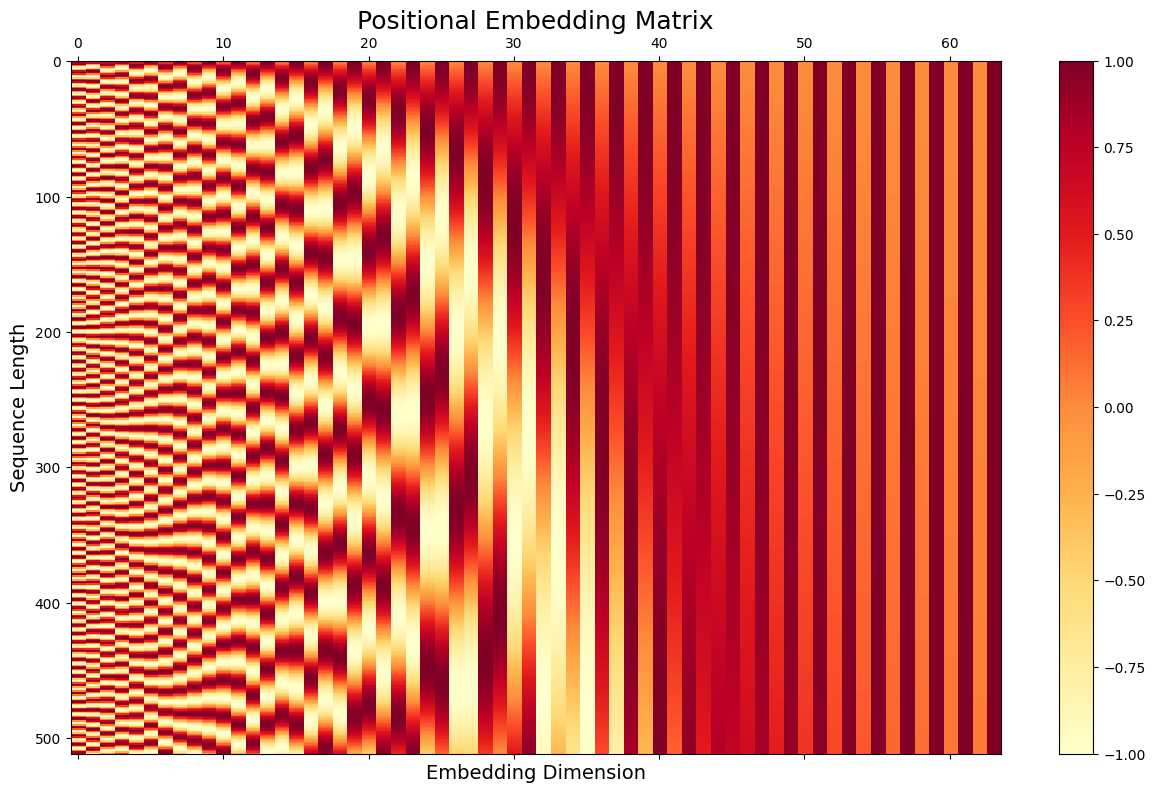

In [15]:
import matplotlib.pyplot as plt
# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(model.encoder.embed_positions.weight.data.cpu().numpy(), aspect='auto',cmap=plt.cm.YlOrRd)
fig.colorbar(cax)
ax.set_title('Positional Embedding Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
ax.set_ylabel('Sequence Length', fontsize=14)

## 2. Attention visualization

In [16]:
from attentionviz import head_view

BATCH_SIZE = 1

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model.eval()

Transformer(
  (enc_embedding): Embedding(13582, 64, padding_idx=0)
  (dec_embedding): Embedding(13582, 64, padding_idx=0)
  (encoder): Encoder(
    (embed_tokens): Embedding(13582, 64, padding_idx=0)
    (embed_positions): SinusoidalPositionalEmbedding(512, 64)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_proj): Linear(in_features=64, out_features=64, bias=False)
          (k_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_proj): Linear(in_features=64, out_features=64, bias=False)
          (out_proj): Linear(in_features=64, out_features=64, bias=False)
        )
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (PositionWiseFeedForward): PositionWiseFeedForward(
          (activation): ReLU()
          (w_1): Linear(in_features=64, out_features=256, bias=True)
          (w_2): Linear(in_features=256, out_features=64, bias

In [17]:
import sys
if not 'attentionviz' in sys.path:
  sys.path += ['attentionviz']
!pip install regex

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [18]:
SAMPLE_IDX = 131

sample = test_data[SAMPLE_IDX]

src_numericalized = torch.LongTensor([SRC_vocab.numericalize(sample['SRC'])]).to(device)
trg_numericalized = torch.LongTensor([TRG_vocab.numericalize(sample['TRG'])]).to(device)

with torch.no_grad():
    output, enc_attention_score, dec_attention_score = model(src_numericalized, trg_numericalized) # turn off teacher forcing
    attention_score = {'self': enc_attention_score, 'cross': dec_attention_score}

src_tok = [SRC_vocab.itos[x] for x in src_numericalized.squeeze()]
trg_tok = [TRG_vocab.itos[x] for x in trg_numericalized.squeeze()]

call_html()
head_view(attention_score, src_tok, trg_tok)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>